In [1]:
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(harmony))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))

In [2]:
set.seed(42)

In [3]:
proj <- loadArchRProject("../data/snATAC", showLogo = FALSE)

Successfully loaded ArchRProject!



ArchR logging to : ArchRLogs/ArchR-plotEmbedding-2e216644f847cd-Date-2022-03-11_Time-19-14-55.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-2e216644f847cd-Date-2022-03-11_Time-19-14-55.log



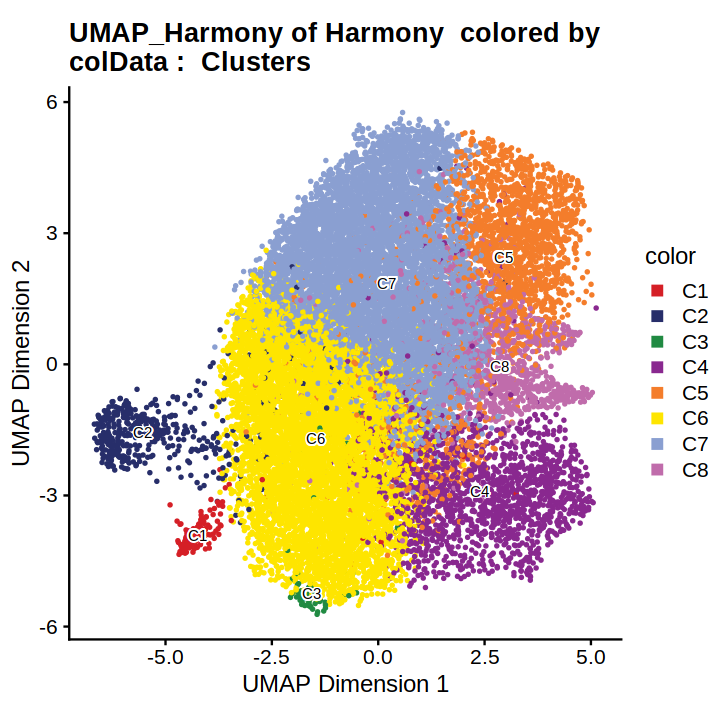

In [4]:
p1 <- plotEmbedding(ArchRProj = proj, 
              colorBy = "cellColData", 
              name = "Clusters", embedding = "UMAP_Harmony",plotAs = "points",
                   size = 0.5, labelAsFactors = FALSE, rastr = FALSE) +
    theme_cowplot()

options(repr.plot.height = 6, repr.plot.width = 6)

p1

In [6]:
df <- proj@cellColData %>%
    as.data.frame() %>%
    group_by(Clusters) %>%
    summarise(mean_nFrags = mean(nFrags))

df

Clusters,mean_nFrags
<chr>,<dbl>
C1,8102.77
C2,42372.73
C3,36018.52
C4,44422.17
C5,41299.81
C6,42305.12
C7,26747.20
C8,26856.00


In [5]:
table(proj@cellColData$Clusters)


  C1   C2   C3   C4   C5   C6   C7   C8 
 148  424   71 1654 2143 7368 7652 1042 

1 


1 


Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


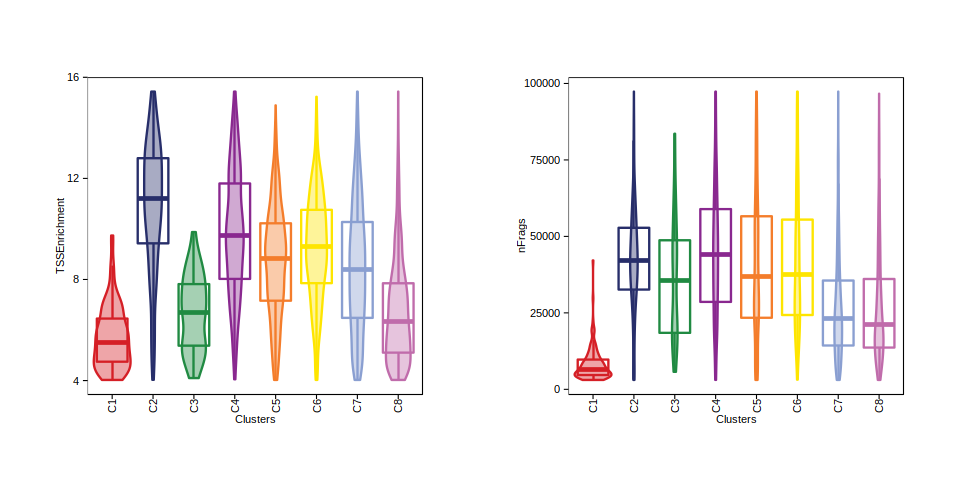

In [9]:
options(repr.plot.height = 4, repr.plot.width = 8)

p1 <- plotGroups(
    ArchRProj = proj, 
    groupBy = "Clusters", 
    colorBy = "cellColData", 
    name = "TSSEnrichment",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
   )

p2 <- plotGroups(
    ArchRProj = proj, 
    groupBy = "Clusters", 
    colorBy = "cellColData", 
    name = "nFrags",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
   )


p1 + p2

In [ ]:
peak_counts <- readRDS("../data/snATAC/PeakMatrix.Rds")
dim(peak_counts)

In [48]:
## cluster 1-3 seems to be outlier, we here removed it from downstream analysis
metadata <- as.data.frame(proj@cellColData) %>%
    subset(., select = c("Sample", "Clusters", "region", "patient", "patient_region_id", "patient_group")) %>%
    subset(., Clusters %in% c("C4", "C5", "C6", "C7", "C8") )


head(metadata)

peak_counts_sub <- peak_counts[, rownames(metadata)]

dim(peak_counts_sub)

,Sample,Clusters,region,patient,patient_region_id,patient_group
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CK171#AGGCGTCCACCATTCC-1,CK171,C5,RZ/BZ,P2,RZ/BZ_P2,group_1
CK171#TGATCAGAGGTAAGTT-1,CK171,C6,RZ/BZ,P2,RZ/BZ_P2,group_1
CK171#TAGCATGCAAGTCTCA-1,CK171,C5,RZ/BZ,P2,RZ/BZ_P2,group_1
CK171#TACATTCCAAACCTAC-1,CK171,C6,RZ/BZ,P2,RZ/BZ_P2,group_1
CK171#CACCACTGTCGCTAGC-1,CK171,C5,RZ/BZ,P2,RZ/BZ_P2,group_1
CK171#GTCACCTAGGAAGGTA-1,CK171,C5,RZ/BZ,P2,RZ/BZ_P2,group_1


[1] 521947  19859

In [49]:
table(metadata$Clusters)


  C4   C5   C6   C7   C8 
1654 2143 7368 7652 1042 

In [50]:
chrom_assay <- CreateChromatinAssay(
  counts = peak_counts_sub,
  sep = c("_", "_"),
  min.cells = 500
)

obj.atac <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata,
  names.field = 1, 
  names.delim = "#")

obj.atac

An object of class Seurat 
182116 features across 19859 samples within 1 assay 
Active assay: peaks (182116 features, 0 variable features)

In [ ]:
## add dimension reduced matrix
harmony_matDR <- proj@reducedDims$Harmony$matDR
colnames(harmony_matDR) <- paste0("Harmony_", 1:ncol(harmony_matDR))
harmony_matDR <- harmony_matDR[colnames(obj.atac), ]

obj.atac[["harmony"]] <- CreateDimReducObject(embeddings = harmony_matDR,
                                             assay = DefaultAssay(obj.atac),
                                             key = "Harmony_")

embedding <- proj@embeddings$UMAP_Harmony$df
colnames(embedding) <- paste0("UMAP_", 1:ncol(embedding))
embedding <- embedding[colnames(obj.atac), ]

#head(embedding)
obj.atac[["umap"]] <- CreateDimReducObject(embeddings = as.matrix(embedding),
                                             assay = "peaks",
                                             key = "UMAP_")

In [ ]:
obj.atac <- RunUMAP(obj.atac, 
               dims = 1:30, 
               reduction = 'harmony',
               reduction.name = "umap_harmony",
               reduction.ke = 'umapharmony_',
              verbose = FALSE,
                   min.dist = 0.4)

In [ ]:
cols.clusters <- ArchR::paletteDiscrete(metadata$Clusters)

In [ ]:
options(repr.plot.height = 8, repr.plot.width = 10)
p1 <- DimPlot(obj.atac, group.by = "Clusters", pt.size = 1, cols = cols.clusters)

p1

In [2]:
## load snRNA-seq data
obj.rna <- readRDS("../data/snRNA/snRNA.rds")
obj.rna

An object of class Seurat 
28933 features across 63161 samples within 1 assay 
Active assay: RNA (28933 features, 2000 variable features)
 4 dimensional reductions calculated: pca, harmony, umap, umap_harmony

In [3]:
df_cell_count <- as.data.frame(obj.rna@meta.data) %>%
    group_by(orig.ident) %>%
    summarise(count = n()) %>%
    arrange(desc(count)) %>%
    subset(count > 400)

df_cell_count

orig.ident,count
<chr>,<int>
CK360,8269
CK357,6478
CK163,4990
CK359,4796
CK356,4346
CK374,3996
CK358,3956
CK158,3880
CK160,3813


In [4]:
obj.rna <- subset(obj.rna, orig.ident %in% df_cell_count$orig.ident)
obj.rna

An object of class Seurat 
28933 features across 63161 samples within 1 assay 
Active assay: RNA (28933 features, 2000 variable features)
 4 dimensional reductions calculated: pca, harmony, umap, umap_harmony

In [ ]:
## add gene activity score
gene.activities <- readRDS("../data/snATAC/GeneScoreMatrix.Rds")

dim(gene.activities)

gene.use <- intersect(rownames(gene.activities),
                     rownames(obj.rna))

length(gene.use)

obj.atac[['GeneActivity']] <- CreateAssayObject(counts = gene.activities[gene.use, colnames(obj.atac)])

DefaultAssay(obj.atac) <- "GeneActivity"

obj.atac <- obj.atac %>% 
        NormalizeData() %>%
        FindVariableFeatures() %>%
        ScaleData()

In [ ]:
transfer.anchors <- FindTransferAnchors(reference = obj.rna,
                                        query = obj.atac,
                                        features = gene.use,
                                        reference.assay = "RNA",
                                        query.assay = "GeneActivity",
                                        reduction = "cca")

In [ ]:
# note that we restrict the imputation to variable genes from scRNA-seq, but could impute the
# full transcriptome if we wanted to
refdata <- GetAssayData(obj.rna, assay = "RNA", slot = "data")[gene.use, ]

# refdata (input) contains a scRNA-seq expression matrix for the scRNA-seq cells. imputation
# (output) will contain an imputed scRNA-seq matrix for each of the ATAC cells
imputation <- TransferData(anchorset = transfer.anchors, 
                           refdata = refdata, 
                           weight.reduction = obj.atac[["harmony"]],
                           dims = 1:30)
obj.atac[["RNA"]] <- imputation

In [ ]:
DefaultAssay(obj.atac) <- "RNA"
obj.rna$tech <- "RNA"
obj.atac$tech <- "ATAC"
coembed <- merge(x = obj.atac, y = obj.rna)

In [ ]:
#Finally, we run PCA and UMAP on this combined object, to visualize the co-embedding of both datasets
coembed <- coembed %>%
    ScaleData(features = gene.use, do.scale = FALSE) %>%
    FindVariableFeatures() %>%
    RunPCA() %>%
    RunUMAP(dims = 1:30, verbose = FALSE)

In [ ]:
saveRDS(obj.rna, file = "../data/snRNA/snRNA.Rds")
saveRDS(obj.atac, file = "../data/snATAC/snATAC.Rds")
saveRDS(coembed, file = "../data/coembed/coembed.Rds")

In [ ]:
sessionInfo()